# Sentiment Analysis - Labelled Financial News Data

This notebook focuses on conducting sentiment analysis using labeled financial news data. This involves analysing the sentiment expressed in financial news articles and categorising them as positive, negative, or neutral. The task includes understanding the characteristics of the dataset, exploring its content, preprocessing the text data, selecting appropriate feature representation techniques, training sentiment classifiers, and evaluating their performance. The objective is to develop accurate sentiment analysis models tailored to the financial domain.

The data is sourced from The Economic Times (Excluding the copyrighted Prime Articles)


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tessa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tessa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First let's load the dataset and take a look at the first few rows.

In [38]:
# Load the data from the CSV file with utf-8 encoding
news = pd.read_csv('data/Fin_cleaned.csv', encoding='utf-8')

news

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive
...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",Negative
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,Negative
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,Negative
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,Positive


In [39]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date_published  400 non-null    object
 1   Headline        400 non-null    object
 2   Synopsis        399 non-null    object
 3   Full_text       400 non-null    object
 4   Final Status    400 non-null    object
dtypes: object(5)
memory usage: 15.8+ KB


There is a missing synopsis value in the dataset.

In [40]:
# print the row with the missing value for the 'synopsis' column
news[news['Synopsis'].isnull()]

,Date_published,Headline,Synopsis,Full_text,Final Status
56,2022-04-08,RBI keeps repo rate unchanged; reduces growth ...,NaN,ANIStory outlineThe benchmark repo rate stands...,Negative


Fill the missing value with an empty string.

In [41]:
# fill the missing value with an empty string
news['Synopsis'] = news['Synopsis'].fillna('')

Let's remane the columns to make it more readable.

In [42]:
# rename columns
news = news.rename(columns={'Date_published': 'date', 'Headline': 'headline', 'Synopsis': 'synopsis', 'Full_text': 'text', 'Final Status': 'label'})
news.head()

,date,headline,synopsis,text,label
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


Check what kind of labels we have

In [43]:
# print unique labels
print(news.label.unique())

['Negative' 'Positive' 'Positive ']


Let's check how many of each we have

In [44]:
# print the number of news articles for each label
print(news.label.value_counts())


label
Positive     215
Negative     184
Positive       1
Name: count, dtype: int64


There are 2 labels for positive values: 'Positive' and 'Positive '. 

In [45]:
# remove the spaces from the labels
news['label'] = news['label'].str.strip()

Now, there only two correct labels: 'Positive' and 'Negative'

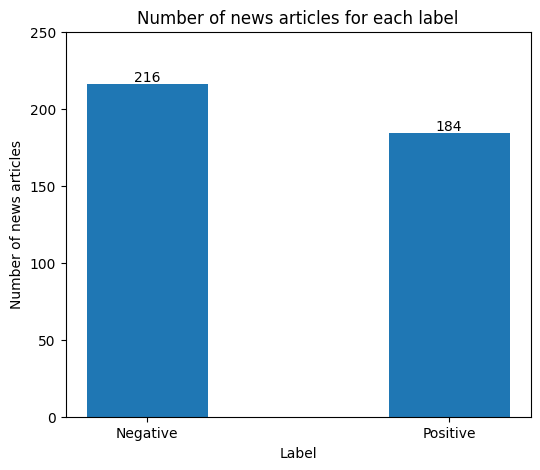

In [46]:
# plot the number of news articles for each label
fig = plt.figure(figsize=(6, 5))
plt.bar(news.label.unique(), news.label.value_counts(), width=0.4)
plt.title('Number of news articles for each label')
plt.xlabel('Label')
plt.ylabel('Number of news articles')
# add the number of news articles on top of each bar
for i, count in enumerate(news.label.value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')
# increase the margin at the top of each bar
plt.ylim(0, 250)
plt.show()

In [47]:
text_columns = ['headline', 'synopsis', 'text']
word_tokens_columns = []
sent_tokens_columns = []
for col in text_columns:
    news[col] = news[col].astype(str)


In [48]:
# # create a sentence token column for each text column
# for col in text_columns:
#     # create a new column with the sentence tokens
#     news[col + '_sent_tokens'] = news[col].apply(sent_tokenize)
#     # count the number of sentence tokens
#     news[col + '_sent_tokens_count'] = news[col + '_sent_tokens'].apply(len)
#     # add the column to the list
#     sent_tokens_columns.append(col + '_sent_tokens')


# create a word token column for each text column
for col in text_columns:
    # create a new column with the word tokens
    news[col + '_word_tokens'] = news[col].apply(word_tokenize)
    # count the number of word tokens
    news[col + '_word_tokens_count'] = news[col + '_word_tokens'].apply(len)
    # add the column to the list
    word_tokens_columns.append(col + '_word_tokens')

news

,date,headline,synopsis,text,label,headline_word_tokens,headline_word_tokens_count,synopsis_word_tokens,synopsis_word_tokens_count,text_word_tokens,text_word_tokens_count
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative,"[Banks, holding, on, to, subsidy, share, ,, sa...",10,"[The, companies, have, written, to, the, Natio...",33,"[ReutersPayments, companies, and, banks, are, ...",547
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive,"[Digitally, ready, Bank, of, Baroda, aims, to,...",11,"[At, present, ,, 50, %, of, the, bank, 's, ret...",43,"[AgenciesThe, bank, presently, has, 20, millio...",490
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive,"[Karnataka, attracted, investment, commitment,...",14,"[Karnataka, is, at, the, forefront, in, attrac...",55,"[PTIKarnataka, Chief, Minister, Basavaraj, Bom...",1062
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative,"[Splitting, of, provident, fund, accounts, may...",8,"[The, EPFO, is, likely, to, split, accounts, o...",56,"[Getty, ImagesThe, budget, for, FY22, had, imp...",424
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive,"[Irdai, weighs, proposal, to, privatise, Insur...",8,"[Set, up, in, 2009, as, an, advisory, body, ,,...",45,"[AgenciesThere, is, a, view, in, the, insuranc...",262
...,...,...,...,...,...,...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",Negative,"[Banks, take, a, cue, from, RBI, ,, hike, lend...",10,"[These, banks, raised, their, respective, exte...",49,"[PTIICICI, Bank, ,, Bank, of, Baroda, ,, Punja...",717
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,Negative,"[Sebi, issues, Rs, 27, lakh, recovery, notice,...",16,"[In, the, event, of, non-payment, ,, it, will,...",62,"[ReutersThe, logo, of, the, Securities, and, E...",253
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,Negative,"[Apollo, Hospital, shares, drop, 0.68, %, as, ...",9,"[A, total, of, 10,105, shares, changed, hands,...",15,"[Getty, ImagesShrikant, Chouhan, of, Kotak, Se...",226
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,Positive,"[SBI, at, Rs, 710, ?, What, makes, analysts, s...",17,"[Calling, the, stock, 'attractively, valued, '...",54,"[AgenciesThe, PSU, bank, reported, a, 41.27, p...",710


Let's convert the word tokens to lowercase

In [49]:
# convert the text to lowercase
for col in word_tokens_columns:
    news[col] = news[col].apply(lambda x: [word.lower() for word in x])

Now let's remove the punctuation and the stopwords

In [52]:
# remove punctuation
for col in word_tokens_columns:
    news[col] = news[col].apply(lambda tokens: [token for token in tokens if token not in string.punctuation])

In [53]:
# remove stopwords
stop_words = set(stopwords.words('english'))
for col in word_tokens_columns:
    news[col] = news[col].apply(lambda tokens: [token for token in tokens if token not in stop_words])

In [54]:
# create word2vec model
from gensim.models import Word2Vec

# create a word2vec model for the 'text' column
word2vec_model = Word2Vec(news['text_word_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# get the embeddings for each token in the tokens columns list
for col in word_tokens_columns:
    # create a new column with the embeddings
    news[col + '_embeddings'] = news[col].apply(lambda tokens: [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv.key_to_index])

news

,date,headline,synopsis,text,label,headline_word_tokens,headline_word_tokens_count,synopsis_word_tokens,synopsis_word_tokens_count,text_word_tokens,text_word_tokens_count,headline_word_tokens_embeddings,synopsis_word_tokens_embeddings,text_word_tokens_embeddings
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative,"[banks, holding, subsidy, share, say, payments...",10,"[companies, written, national, payments, corp....",33,"[reuterspayments, companies, banks, loggerhead...",547,"[[-0.16033694, 1.0625873, 0.12790872, 0.415251...","[[-0.18779692, 1.2458323, 0.12436837, 0.504265...","[[-0.0057538683, -0.0028842394, -0.00035643604..."
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive,"[digitally, ready, bank, baroda, aims, click, ...",11,"[present, 50, bank, 's, retail, loans, sourced...",43,"[agenciesthe, bank, presently, 20, million, ac...",490,"[[-0.015602389, 0.08622267, 0.01480356, 0.0323...","[[-0.032471582, 0.15534747, 0.021472057, 0.052...","[[-0.009739796, 0.09423736, 0.0027427934, 0.02..."
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive,"[karnataka, attracted, investment, commitment,...",14,"[karnataka, forefront, attracting, investments...",55,"[ptikarnataka, chief, minister, basavaraj, bom...",1062,"[[-0.0065532355, 0.09465571, 0.016840031, 0.04...","[[-0.0065532355, 0.09465571, 0.016840031, 0.04...","[[0.0024935226, 0.010883538, 0.008237147, -0.0..."
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative,"[splitting, provident, fund, accounts, may, de...",8,"[epfo, likely, split, accounts, time, creditin...",56,"[getty, imagesthe, budget, fy22, imposed, inco...",424,"[[-0.003268475, 0.014652249, 0.005973749, 0.01...","[[-0.004669613, 0.08874926, 0.009226709, 0.028...","[[-0.03520187, 0.43477458, 0.025583, 0.1807238..."
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive,"[irdai, weighs, proposal, privatise, insurance...",8,"[set, 2009, advisory, body, iib, collects, tra...",45,"[agenciesthere, view, insurance, industry, iib...",262,"[[-0.014914398, 0.10723432, 0.024454128, 0.047...","[[-0.10761959, 0.6552871, 0.082613625, 0.25594...","[[-0.00085203524, 0.007740315, -0.0012712906, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",Negative,"[banks, take, cue, rbi, hike, lending, rates]",10,"[banks, raised, respective, external, benchmar...",49,"[ptiicici, bank, bank, baroda, punjab, nationa...",717,"[[-0.16033694, 1.0625873, 0.12790872, 0.415251...","[[-0.16033694, 1.0625873, 0.12790872, 0.415251...","[[0.0015000658, 0.0057257256, 0.0050411327, 0...."
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,Negative,"[sebi, issues, rs, 27, lakh, recovery, notice,...",16,"[event, non-payment, recover, amount, attachin...",62,"[reutersthe, logo, securities, exchange, board...",253,"[[-0.093856916, 0.51655644, 0.071439385, 0.206...","[[-0.026152613, 0.09448262, 0.013831997, 0.038...","[[-0.0009943374, 0.014131133, 0.0034656979, 0...."
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,Negative,"[apollo, hospital, shares, drop, 0.68

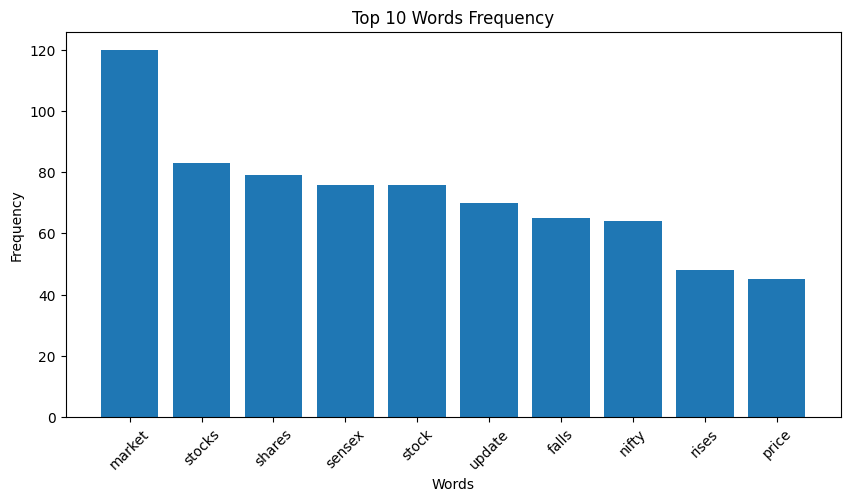

In [57]:
from collections import Counter
from itertools import chain

# Flatten the list of lists
all_words = list(chain.from_iterable(news['headline_word_tokens']))

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the top N words and their frequencies
top_words = word_freq.most_common(10)

# Extract words and frequencies
top_words, freq = zip(*top_words)

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(top_words, freq)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Frequency')
plt.xticks(rotation=45)
plt.show()

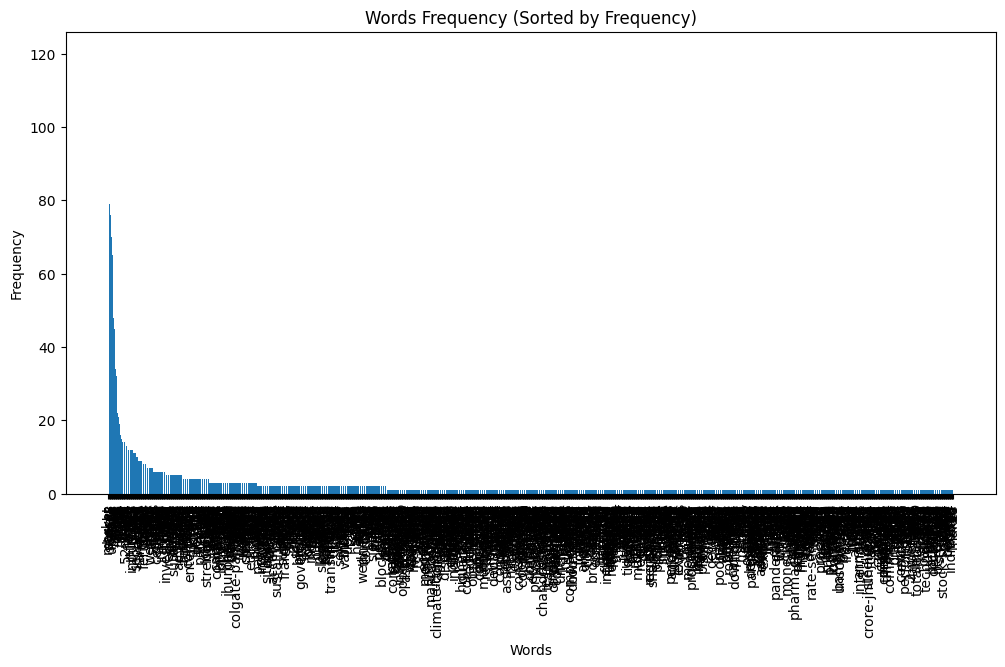

In [59]:
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

# Flatten the list of lists
all_words = list(chain.from_iterable(news['headline_word_tokens']))

# Count the frequency of each word
word_freq = Counter(all_words)

# Sort words by frequency
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Extract sorted words and frequencies
words, freq = zip(*sorted_words)

# Plot the bar chart with all words sorted by frequency
plt.figure(figsize=(12, 6))
plt.bar(words, freq)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Words Frequency (Sorted by Frequency)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()